# Setup

In [1]:
import json
import os
import sys
import string

sys.path.append('..')

import rasterio
from rasterio.enums import Resampling
import geopandas as gpd
import fiona

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

from utils import read_csv_non_utf, match_to_closest_year, extract_year

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']

# Grabbing population density raster
year = 2000
pop_dens_paths = config['indiv_data_paths']['human_pop_density']
human_pop_dens2000 = os.path.join(pop_dens_paths['base_path'], pop_dens_paths['data_path'].format(year, year))
pop_dens_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, human_pop_dens2000)

# Grabbing Benitez-Lopez
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']
ben_lop_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)

# Grabbing global protected areas - just one of the three files, to make things run quicker...
protected_areas_paths = config['indiv_data_paths']['protected_areas']
subset = protected_areas_paths['subsets'][0]
protected_areas_subset = os.path.join(protected_areas_paths['base_path'], protected_areas_paths['data_path'].format(subset))
PAs_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, protected_areas_subset)

# Loading population density raster

In [ ]:
# Resampling the array for visualization: https://rasterio.readthedocs.io/en/stable/topics/resampling.html
#  - probably better practice to download pre-prepared lower resolution versions from NASA, but this works for now!
upscale_factor = 1 / 20

with rasterio.open(pop_dens_path) as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape = (
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling = Resampling.average # seems the most reasonable resampling methods, since we're dealing with densities
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

data[data < 0] = np.nan # turning the fill value into NaN

# Plotting data

In [ ]:
# Below code for color-mapping is from: https://stackoverflow.com/questions/61897393/unevenly-irregularly-spaced-data-for-colorbar-with-evenly-spaced-colors
uneven_levels = [0, 1, 5, 25, 250, 1000, 60000] # to match the SEDAC plot
cmap = plt.get_cmap('YlOrRd')
colors = cmap(np.linspace(0, 1, len(uneven_levels) - 1))
cmap, norm = mcolors.from_levels_and_colors(uneven_levels, colors)

# Setting things up for cartopy
xmin, ymin, xmax, ymax = list(dataset.bounds)

fig = plt.figure(figsize = (10, 14))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Mollweide())
ax.add_feature(cartopy.feature.BORDERS, linewidth = 0.5, zorder = 20)
ax.add_feature(cartopy.feature.COASTLINE, linewidth = 0.5, zorder = 20)

gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = False, linewidth = 0.5, color = 'gray', alpha = 0.5, zorder = 0)

# Plotting the data
im = ax.imshow(data.squeeze(), 
               cmap = cmap, norm = norm, 
               origin = 'upper', transform = ccrs.PlateCarree(), extent = [xmin, xmax, ymin, ymax],
               zorder = 10)

plt.colorbar(im, ax = ax, fraction = 0.025, pad = 0.04, orientation = 'horizontal')

# plt.savefig('/Users/emiliolr/Desktop/pop_density_map.png', bbox_inches = 'tight', dpi = 300)
plt.show();

# Extracting pixel values for a study location

For population density data, we don't need to re-project the coordinates since the data is already in WGS84 format. For others, we might need to project the desired lat/lon into coordinates for the data's CRS, then index.

In [ ]:
# Grabbing a window around a desired lat/lon for a sanity check 
lat, lon = 38.8816, -77.0910 # Arlington, VA
N = 800

with rasterio.open(pop_dens_path) as dataset:
    py, px = dataset.index(lon, lat)
    window = rasterio.windows.Window(px - N // 2, py - N // 2, N, N)
    clip = dataset.read(1, window = window)

clip[clip < 0] = np.nan

In [ ]:
# Plotting the window which should be centered on Arlington, VA (blue dot) - looks correct to me!
plt.scatter([N // 2], [N // 2], s = 50, c = 'blue', edgecolor = 'white', zorder = 10)
plt.imshow(clip, cmap = cmap, norm = norm, zorder = 0)
plt.colorbar();

## Trying to extend the above to a script using Benitez-Lopez study locations

**TODO:**
- [x] Grab the correct version of the dataset based on the study year (where is study year recorded?)
- [ ] Figure out a better method for extracting the year (publication year may not be close to when the data was collected...)
- [ ] Download [GRUMPv1](https://sedac.ciesin.columbia.edu/data/collection/grump-v1) and use this for 1990 and 1995
   - I imagine the reason why we're not doing great right now on matching the reference values is in part due to thhe fact that we only use [GPWv4](https://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-density-rev11) values 

In [ ]:
# Read in hunting effects dataset
ben_lop2019 = read_csv_non_utf(ben_lop_path)

#  removing spatial predictors - pretending we haven't extracted them yet
cols = ['Reference', 'Study', 'Order', 'Family', 'Species', 'ratio', 
        'RR', 'X', 'Y', 'Region', 'Country', 'BM', 'Diet']
ben_lop2019 = ben_lop2019[cols]

#  grabbing year - for now, just using the publication year...
ben_lop2019['Study_Year'] = ben_lop2019['Reference'].apply(extract_year)
ben_lop2019.head()

In [ ]:
# Matching study years to closest year for the population density dataset
study_years = list(ben_lop2019['Study_Year'])
avail_years = pop_dens_paths['avail_years']
dataset_years = match_to_closest_year(avail_years, study_years)

In [ ]:
# Read in all datasets that we'll need in FULL resolution
pop_dens_data = {}

for year in np.unique(dataset_years):
    data_path = os.path.join(pop_dens_paths['base_path'], pop_dens_paths['data_path'].format(year, year))
    data_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, human_pop_dens2000)
    
    with rasterio.open(data_path) as dataset:
        data = dataset.read(1)
    
    data[data < 0] = np.nan
    
    pop_dens_data[year] = {}
    pop_dens_data[year]['dataset'] = dataset
    pop_dens_data[year]['data'] = data

In [ ]:
# Running through the study locations and grabbing corresponding pixel values from the raster
pop_dens_col = []

for year, lat, lon in zip(dataset_years, ben_lop2019['Y'], ben_lop2019['X']):
    data = pop_dens_data[year]['data']
    dataset = pop_dens_data[year]['dataset']
    
    row, col = dataset.index(lon, lat)
    pop_dens_col.append(data[row, col])

pop_dens_col = np.array(pop_dens_col)

In [ ]:
ref_pop_dens = read_csv_non_utf(ben_lop_path)['PopDens']
mae = np.mean(np.abs((pop_dens_col - ref_pop_dens)))
print(f'Using our extraction method, we achieve a MAPE of {round(mae, 3)}')

# Turning vector data into raster data

In [3]:
# Adapted from: https://gis.stackexchange.com/questions/220023/only-read-specific-rows-of-a-shapefile-with-geopandas-fiona
def read_gpd_subset(filename, num_entries = 100):
    with fiona.open(filename) as source:
        for feature in source[ : num_entries]:
            yield feature

In [4]:
# Loading in protected area polygons (vector data)
pa_data_subset = gpd.GeoDataFrame.from_features(read_gpd_subset(PAs_path, num_entries = 10))
pa_data_subset.head()

,geometry,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,...,OWN_TYPE,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,SUPP_INFO,CONS_OBJ
0,"POLYGON ((-61.82494 17.18497, -61.82497 17.184...",1.0,1,1,Diamond Reef and Salt Fish Tail Reef,Diamond Reef,Marine Reserve,Marine Reserve,National,Ia,...,State,Fisheries Division,Not Reported,State Verified,1807,AG-04,ATG,ATG,Not Applicable,Not Applicable
1,"POLYGON ((-61.74007 17.52001, -61.77174 17.526...",2.0,2,1,Palaster Reef,Palaster Reef,Marine Reserve,Marine Reserve,National,Ia,...,State,Fisheries Division,Not Reported,State Verified,1807,AG-10,ATG,ATG,Not Applicable,Not Applicable
2,"POLYGON ((-65.98955 -22.47423, -65.99441 -22.4...",3.0,3,1,Laguna de los Pozuelos,Laguna de los Pozuelos,Monumento Natural,Nature Monument,National,III,...,Not Reported,Administración de Parques Nacionales,Not Reported,State Verified,1935,AR-Y,ARG,ARG,Not Applicable,Not Applicable
3,"POLYGON ((-61.83791 -24.20686, -61.83781 -24.2...",4.0,4,1,Formosa,Formosa,Reserva Natural,Nature Reserve,National,Ia,...,Not Reported,Administración de Parques Nacionales,https://sib.gob.ar/archivos/plan_de_gestion_RN...,State Verified,1935,AR-P,ARG,ARG,Not Applicable,Not Applicable
4,"POLYGON ((-73.14850 -49.27008, -73.14368 -49.2...",6.0,6,1,Los Glaciares,Los Glaciares,Parque Nacional,National Park,National,II,...,Not Reported,Administración de Parques Nacionales,https://sib.gob.ar/archivos/PG_PN_LOS_GLACIARE...,State Verified,1935,AR-Z,ARG,ARG,Not Applicable,Not Applicable


In [5]:
from shapely import unary_union

all_pas = unary_union(pa_data_subset['geometry'])

# Interfacing with GEE

This is code bits both for post-processed GEE data and for pre-processing hunting data for upload to GEE.

## Subsetting and cleaning for export to GEE

In [12]:
# Inspecting duplicated columns... many of these vary only by PREDICTORS (usually DistKm) not IDENTIFIERS 
#  so I think they should legitimately be considered duplicates!
ben_lop2019 = read_csv_non_utf(ben_lop_path)

cols = ['Reference', 'Study', 'Order', 'Family', 'Species', 'Region', 'Country', 'ratio', 'X', 'Y']
ben_lop2019[ben_lop2019.duplicated(cols, False)].sort_values(by = cols).head(5)

,Reference,Study,Order,Family,Species,ratio,RR,X,Y,Region,Country,BM,Diet,DistKm,Reserve,TravTime,LivestockBio,Stunting,PopDens,Literacy
1576,"Baur, 1998",95,Cetartiodactyla,Cervidae,Odocoileus virginianus,0.333333,-1.098155,-90.055,17.461,C America,Guatemala,55.51,Herb,6.0,Yes,777.000000,8202.820168,46.2,3.082,64.2
1583,"Baur, 1998",95,Cetartiodactyla,Cervidae,Odocoileus virginianus,0.333333,-1.098155,-90.055,17.461,C America,Guatemala,55.51,Herb,10.0,Yes,777.000000,8202.820168,46.2,3.082,64.2
1581,"Baur, 1998",95,Cetartiodactyla,Tayassuidae,Tayassu pecari,0.000000,-8.789051,-90.055,17.461,C America,Guatemala,32.23,Frug,6.0,Yes,777.000000,8202.820168,46.2,3.082,64.2
1588,"Baur, 1998",95,Cetartiodactyla,Tayassuidae,Tayassu pecari,0.000000,-8.789051,-90.055,17.461,C America,Guatemala,32.23,Frug,10.0,Yes,777.000000,8202.820168,46.2,3.082,64.2
571,"Blake et al., 2007",32,Proboscidea,Elephantidae,Loxodonta africana,0.000000,-8.789051,20.651,-1.991,Africa,D.R. Congo,3940.03,Herb,32.5,Yes,917.866667,0.000000,50.9,5.903,61.2


In [13]:
# Saving a subsetted version of Benitez-Lopez 2019 (in terms of columns) for use in GEE
ben_lop2019_sub = ben_lop2019[cols].copy(deep = True)
ben_lop2019_sub = ben_lop2019_sub.drop_duplicates()
ben_lop2019_sub['lon,lat'] = ben_lop2019_sub['X'].astype(str) + ',' + ben_lop2019_sub['Y'].astype(str)

save_fp = '/Users/emiliolr/Desktop/hunting_sites.csv'
ben_lop2019_sub.to_csv(save_fp, index = False)

ben_lop2019_sub.head()

,Reference,Study,Order,Family,Species,Region,Country,ratio,X,Y,"lon,lat"
0,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",Africa,Gabon,0.377193,9.839,-1.916,"9.839,-1.916"
1,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,Africa,Gabon,0.865690,9.839,-1.916,"9.839,-1.916"
2,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",Africa,Gabon,0.833333,9.839,-1.916,"9.839,-1.916"
3,"Laurance et al., 2006",1,Proboscidea,Elephantidae,Loxodonta africana,Africa,Gabon,0.900862,9.839,-1.916,"9.839,-1.916"
4,"Laurance et al., 2006",1,Cetartiodactyla,Bovidae,"Cephalophus callipygus, C. dorsalis, C. leucog...",Africa,Gabon,0.956140,9.839,-1.916,"9.839,-1.916"


## Reading in GEE data (with spatial predictors)

### WDPA-specific stuff

In [57]:
# Read in the WDPA dataset
fp = os.path.join(gdrive_fp, 'gee_testing', 'wdpa_study_sites.csv')
studies_PAs = pd.read_csv(fp)
studies_PAs = studies_PAs.drop(columns = ['system:index', '.geo'])

#  adding back in X and Y columns
studies_PAs['X'] = studies_PAs['lon,lat'].apply(lambda x: float(x.split(',')[0]))
studies_PAs['Y'] = studies_PAs['lon,lat'].apply(lambda x: float(x.split(',')[1]))
studies_PAs = studies_PAs.drop(columns = ['lon,lat'])

studies_PAs.head()

,Country,Family,Order,PA,PA_year,Reference,Region,Species,Study,ratio,X,Y
0,Ethiopia,Bovidae,Cetartiodactyla,1,1969.0,"Atickem et al., 2011",Africa,Tragelaphus buxtoni,27,0.757073,39.743,7.100
1,Ethiopia,Bovidae,Cetartiodactyla,1,NaN,"Atickem et al., 2011",Africa,Tragelaphus buxtoni,27,0.961951,40.306,6.879
2,Ethiopia,Bovidae,Cetartiodactyla,1,2013.0,"Atickem et al., 2011",Africa,Tragelaphus buxtoni,27,1.000000,40.177,6.873
3,Ethiopia,Bovidae,Cetartiodactyla,1,2013.0,"Atickem et al., 2011",Africa,Tragelaphus buxtoni,28,0.572368,39.700,7.224
4,Ethiopia,Bovidae,Cetartiodactyla,1,2013.0,"Atickem et al., 2011",Africa,Tragelaphus buxtoni,28,0.638158,39.648,7.156


In [58]:
# Filling in the final PA column: this is 1 if both
#  (1) PA > 1 (i.e., the point intersects at least one PA)
#  (2) PA_year <= reference year
studies_PAs['study_year'] = studies_PAs['Reference'].apply(extract_year)
studies_PAs['PA_final'] = ((studies_PAs['PA'] > 0) & (studies_PAs['PA_year'] <= studies_PAs['study_year'])).astype(int)
studies_PAs = studies_PAs.drop(columns = ['PA', 'PA_year', 'study_year'])

studies_PAs.head()

,Country,Family,Order,Reference,Region,Species,Study,ratio,X,Y,PA_final
0,Ethiopia,Bovidae,Cetartiodactyla,"Atickem et al., 2011",Africa,Tragelaphus buxtoni,27,0.757073,39.743,7.100,1
1,Ethiopia,Bovidae,Cetartiodactyla,"Atickem et al., 2011",Africa,Tragelaphus buxtoni,27,0.961951,40.306,6.879,0
2,Ethiopia,Bovidae,Cetartiodactyla,"Atickem et al., 2011",Africa,Tragelaphus buxtoni,27,1.000000,40.177,6.873,0
3,Ethiopia,Bovidae,Cetartiodactyla,"Atickem et al., 2011",Africa,Tragelaphus buxtoni,28,0.572368,39.700,7.224,0
4,Ethiopia,Bovidae,Cetartiodactyla,"Atickem et al., 2011",Africa,Tragelaphus buxtoni,28,0.638158,39.648,7.156,0


In [59]:
# Sanity checking...
print(f'With the year-checking methodology, {round(studies_PAs['PA_final'].mean() * 100, 2)}% of studies sites are in PAs')

With the year-checking methodology, 61.46% of studies sites are in PAs


### Reading in and cleaning other predictors

In [52]:
# Reading in the GEE dataset, with pixel values extracted for spatial predictors
fp = os.path.join(gdrive_fp, 'gee_testing', 'spatial_preds_study_sites.csv')
table_pts = pd.read_csv(fp)
table_pts.head()

,system:index,Country,Family,Order,Reference,Region,Species,Study,dataset_id,"lon,lat",mean,ratio,.geo
0,1_0_00000000000000000200,Ethiopia,Bovidae,Cetartiodactyla,"Atickem et al., 2011",Africa,Tragelaphus buxtoni,27,users/el590/povmap-grdi-v1,"39.743,7.1",95.336304,0.757073,"{""type"":""Polygon"",""coordinates"":[[[39.74300006..."
1,1_0_00000000000000000201,Ethiopia,Bovidae,Cetartiodactyla,"Atickem et al., 2011",Africa,Tragelaphus buxtoni,27,users/el590/povmap-grdi-v1,"40.306,6.879",NaN,0.961951,"{""type"":""Polygon"",""coordinates"":[[[40.30600170..."
2,1_0_00000000000000000202,Ethiopia,Bovidae,Cetartiodactyla,"Atickem et al., 2011",Africa,Tragelaphus buxtoni,27,users/el590/povmap-grdi-v1,"40.177,6.873",NaN,1.000000,"{""type"":""Polygon"",""coordinates"":[[[40.17699991..."
3,1_0_00000000000000000203,Ethiopia,Bovidae,Cetartiodactyla,"Atickem et al., 2011",Africa,Tragelaphus buxtoni,28,users/el590/povmap-grdi-v1,"39.7,7.224",NaN,0.572368,"{""type"":""Polygon"",""coordinates"":[[[39.70000095..."
4,1_0_00000000000000000204,Ethiopia,Bovidae,Cetartiodactyla,"Atickem et al., 2011",Africa,Tragelaphus buxtoni,28,users/el590/povmap-grdi-v1,"39.648,7.156",NaN,0.638158,"{""type"":""Polygon"",""coordinates"":[[[39.64799891..."


In [53]:
# Cleaning up the GEE outputted dataset
cols_to_keep = ['Reference', 'Study', 'Order', 'Family', 'Species', 'Country', 'Region', 'lon,lat', 'ratio', 'dataset_id', 'mean']
table_pts_sub = table_pts[cols_to_keep].copy(deep = True)

#  cleaning up dataset column
table_pts_sub['dataset'] = table_pts_sub['dataset_id'].apply(lambda x: x.split('/')[-1])
table_pts_sub = table_pts_sub.drop(columns = ['dataset_id'])

#  adding back in X and Y columns
table_pts_sub['X'] = table_pts_sub['lon,lat'].apply(lambda x: float(x.split(',')[0]))
table_pts_sub['Y'] = table_pts_sub['lon,lat'].apply(lambda x: float(x.split(',')[1]))
table_pts_sub = table_pts_sub.drop(columns = ['lon,lat'])

#  turning predictors into columns
index_cols = [c for c in table_pts_sub.columns if c not in ['dataset', 'mean']]
table_pts_sub = table_pts_sub.pivot_table(values = 'mean', columns = 'dataset', index = index_cols)
table_pts_sub = table_pts_sub.reset_index()
table_pts_sub = table_pts_sub.rename_axis('', axis = 'columns')

#  renaming columns
new_col_names = {'gpw_v4_population_density_rev11_2000_30_sec' : 'PopDens2000',
                 'gpw_v4_population_density_rev11_2005_30_sec' : 'PopDens2005',
                 'gpw_v4_population_density_rev11_2010_30_sec' : 'PopDens2010',
                 'gpw_v4_population_density_rev11_2015_30_sec' : 'PopDens2015', 
                 'gpw_v4_population_density_rev11_2020_30_sec' : 'PopDens2020',
                 'povmap-grdi-v1' : 'PovertyIndex',
                 'travel_time_to_cities_9' : 'TravelTimeSmallCity',
                 'wdpa_mask' : 'ProtectedArea2024',
                 'wdpa_mask_2017' : 'ProtectedArea2017',
                 'wdpa_mask_stringent' : 'ProtectedAreaStringent'}
table_pts_sub = table_pts_sub.rename(columns = new_col_names)

table_pts_sub.head()

,Reference,Study,Order,Family,Species,Country,Region,ratio,X,Y,PopDens2000,PopDens2005,PopDens2010,PopDens2015,PopDens2020,PovertyIndex,TravelTimeSmallCity,ProtectedArea2024,ProtectedArea2017,ProtectedAreaStringent
0,"Aliaga-Rossel, 2011",170,Carnivores,Canidae,Cerdocyon thous,Bolivia,S America,0.000000,-67.5185,-14.6397,3.430563,4.020985,4.713758,5.526776,6.481094,NaN,510.0,1.0,1.0,0.0
1,"Aliaga-Rossel, 2011",170,Carnivores,Canidae,Cerdocyon thous,Bolivia,S America,1.000000,-67.7220,-14.6220,0.914427,1.109513,1.346219,1.633424,1.981903,NaN,787.0,1.0,1.0,0.0
2,"Aliaga-Rossel, 2011",170,Carnivores,Canidae,Cerdocyon thous,Bolivia,S America,1.000000,-67.5650,-14.7230,0.914427,1.109512,1.346219,1.633424,1.981903,NaN,572.0,1.0,1.0,0.0
3,"Aliaga-Rossel, 2011",170,Carnivores,Felidae,Leopardus pardalis,Bolivia,S America,0.143885,-67.5650,-14.7230,0.914427,1.109512,1.346219,1.633424,1.981903,NaN,572.0,1.0,1.0,0.0
4,"Aliaga-Rossel, 2011",170,Carnivores,Felidae,Leopardus pardalis,Bolivia,S America,1.000000,-67.7220,-14.6220,0.914427,1.109513,1.346219,1.633424,1.981903,NaN,787.0,1.0,1.0,0.0


In [54]:
# Turning protected area variable back into binary - counts as protected if 50% overlap w/protected area
pa_threshold = 0.5
table_pts_sub['ProtectedArea2024'] = (table_pts_sub['ProtectedArea2024'] > pa_threshold).astype(int)
table_pts_sub['ProtectedArea2017'] = (table_pts_sub['ProtectedArea2017'] > pa_threshold).astype(int)
table_pts_sub['ProtectedAreaStringent'] = (table_pts_sub['ProtectedAreaStringent'] > pa_threshold).astype(int)

In [55]:
# Extract the correct population density value based on the study year and see if we can generalize
#  (imagining we might have multiple spatial predictors with diff layers for diff years)
pop_dens_cols = ['PopDens2000', 'PopDens2005', 'PopDens2010', 'PopDens2015', 'PopDens2020']
years = {int(c.split('s')[-1]) : c for c in pop_dens_cols}

study_years = list(table_pts_sub['Reference'].apply(extract_year))
avail_years = list(y for y in years)
matched_years = match_to_closest_year(avail_years, study_years)

new_pop_dens_col = [table_pts_sub.iloc[i].loc[years[matched_years[i]]] for i in range(len(matched_years))]
table_pts_sub['PopDens'] = new_pop_dens_col

#  removing superfluous columns
table_pts_sub = table_pts_sub.drop(columns = pop_dens_cols)
table_pts_sub.head()

,Reference,Study,Order,Family,Species,Country,Region,ratio,X,Y,PovertyIndex,TravelTimeSmallCity,ProtectedArea2024,ProtectedArea2017,ProtectedAreaStringent,PopDens
0,"Aliaga-Rossel, 2011",170,Carnivores,Canidae,Cerdocyon thous,Bolivia,S America,0.000000,-67.5185,-14.6397,NaN,510.0,1,1,0,4.713758
1,"Aliaga-Rossel, 2011",170,Carnivores,Canidae,Cerdocyon thous,Bolivia,S America,1.000000,-67.7220,-14.6220,NaN,787.0,1,1,0,1.346219
2,"Aliaga-Rossel, 2011",170,Carnivores,Canidae,Cerdocyon thous,Bolivia,S America,1.000000,-67.5650,-14.7230,NaN,572.0,1,1,0,1.346219
3,"Aliaga-Rossel, 2011",170,Carnivores,Felidae,Leopardus pardalis,Bolivia,S America,0.143885,-67.5650,-14.7230,NaN,572.0,1,1,0,1.346219
4,"Aliaga-Rossel, 2011",170,Carnivores,Felidae,Leopardus pardalis,Bolivia,S America,1.000000,-67.7220,-14.6220,NaN,787.0,1,1,0,1.346219


### Merging predictors (WDPA w/non-WDPA)

In [64]:
# Merging in with a join
table_pts_sub = table_pts_sub.join(studies_PAs.set_index(cols), on = cols)
table_pts_sub.head()

,Reference,Study,Order,Family,Species,Country,Region,ratio,X,Y,PovertyIndex,TravelTimeSmallCity,ProtectedArea2024,ProtectedArea2017,ProtectedAreaStringent,PopDens,PA_final
0,"Aliaga-Rossel, 2011",170,Carnivores,Canidae,Cerdocyon thous,Bolivia,S America,0.000000,-67.5185,-14.6397,NaN,510.0,1,1,0,4.713758,1
1,"Aliaga-Rossel, 2011",170,Carnivores,Canidae,Cerdocyon thous,Bolivia,S America,1.000000,-67.7220,-14.6220,NaN,787.0,1,1,0,1.346219,1
2,"Aliaga-Rossel, 2011",170,Carnivores,Canidae,Cerdocyon thous,Bolivia,S America,1.000000,-67.5650,-14.7230,NaN,572.0,1,1,0,1.346219,1
3,"Aliaga-Rossel, 2011",170,Carnivores,Felidae,Leopardus pardalis,Bolivia,S America,0.143885,-67.5650,-14.7230,NaN,572.0,1,1,0,1.346219,1
4,"Aliaga-Rossel, 2011",170,Carnivores,Felidae,Leopardus pardalis,Bolivia,S America,1.000000,-67.7220,-14.6220,NaN,787.0,1,1,0,1.346219,1


In [72]:
# Sanity check: the places where they disagree are all b/c PA_final has stricter criteria, never b/c
#  ProtectedArea2024 is more strict!
disagreement_mask = table_pts_sub['PA_final'] != table_pts_sub['ProtectedArea2024']
print(table_pts_sub[disagreement_mask]['PA_final'].value_counts())
print()
print(table_pts_sub[disagreement_mask]['ProtectedArea2024'].value_counts())

PA_final
0    322
Name: count, dtype: int64

ProtectedArea2024
1    322
Name: count, dtype: int64


### Sanity checks and general spatial predictor validation

In [73]:
# Renaming the two datasets, just to keep things straight + aligning them in terms of values
ben_lop_ORIGINAL = ben_lop2019.copy(deep = True)
ben_lop_ORIGINAL = ben_lop_ORIGINAL.drop_duplicates(subset = cols)
ben_lop_ORIGINAL = ben_lop_ORIGINAL.sort_values(cols)
ben_lop_ORIGINAL = ben_lop_ORIGINAL.reset_index().drop(columns = ['index'])

ben_lop_OURS = table_pts_sub.copy(deep = True)
ben_lop_OURS = ben_lop_OURS.sort_values(cols)
ben_lop_OURS = ben_lop_OURS.reset_index().drop(columns = ['index'])

In [74]:
# Sanity checks - columns that SHOULD NOT have changed!
categorical_cols = ['Reference', 'Order', 'Family', 'Species', 'Country', 'Region']
numerical_cols = ['Study', 'ratio', 'X', 'Y']

for col in numerical_cols:
    num_diff = (~np.isclose(ben_lop_ORIGINAL[col], ben_lop_OURS[col])).sum() # ignore differences in numerical precision
    print(f'{col} columns differ in {num_diff} places')

print()

for col in categorical_cols:
    num_diff = (ben_lop_ORIGINAL[col] != ben_lop_OURS[col]).sum()
    print(f'{col} columns differ in {num_diff} places')

Study columns differ in 0 places
ratio columns differ in 0 places
X columns differ in 0 places
Y columns differ in 0 places

Reference columns differ in 0 places
Order columns differ in 0 places
Family columns differ in 0 places
Species columns differ in 0 places
Country columns differ in 0 places
Region columns differ in 0 places


Mean absolute error for Population Density: 4.739
Mean absolute error for Population Density: 0.147


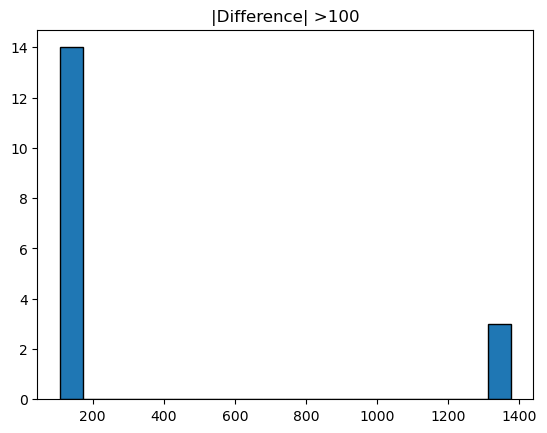

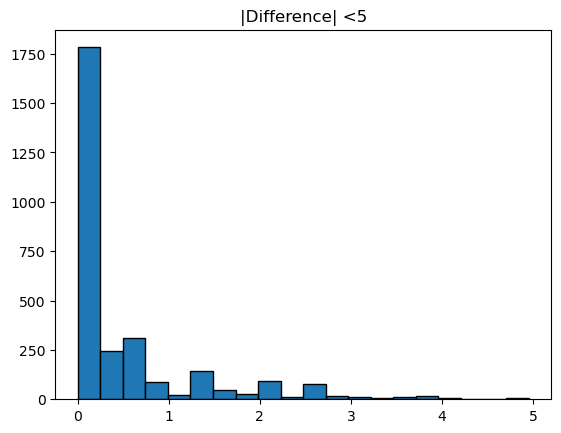

In [75]:
# Taking a look at differences in population density
pop_dens_diff = np.abs(ben_lop_OURS['PopDens'] - ben_lop_ORIGINAL['PopDens'])
pop_dens_mean_ae = round(np.mean(pop_dens_diff), 3)
pop_dens_med_ae = round(np.median(pop_dens_diff), 3)

print(f'Mean absolute error for Population Density: {pop_dens_mean_ae}')
print(f'Mean absolute error for Population Density: {pop_dens_med_ae}')

plt.hist(pop_dens_diff[pop_dens_diff > 100], bins = 20, edgecolor = 'black')
plt.title('|Difference| >100')
plt.show();

plt.hist(pop_dens_diff[pop_dens_diff < 5], bins = 20, edgecolor = 'black')
plt.title('|Difference| <5')
plt.show();

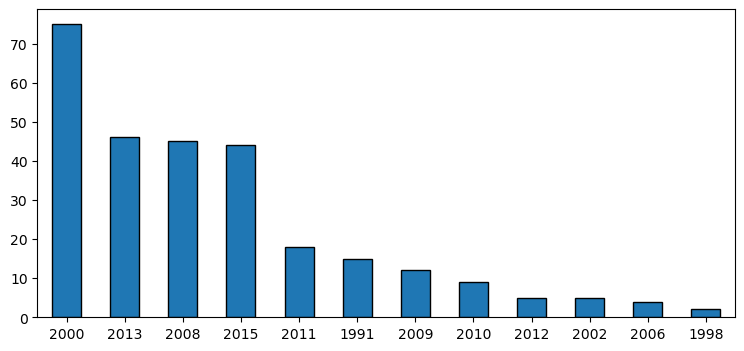

In [76]:
# Where do big differences in population density occur?
#  - if commonly at pre-2000 studies, this might be remedied by adding GRUMP
abs_diff_thresh = 5

study_years = ben_lop_OURS['Reference'].apply(extract_year)
big_diff_years = study_years[pop_dens_diff > abs_diff_thresh]

plt.figure(figsize = (9, 4))
big_diff_years.value_counts().plot.bar(edgecolor = 'black', rot = 0)
plt.xlabel('');

In [78]:
# Taking a look at protected areas
ORIGINAL_binary = (ben_lop_ORIGINAL['Reserve'] == 'Yes').astype(int)

pct_agree2017 = (ben_lop_OURS['ProtectedArea2017'] == ORIGINAL_binary).mean()
print(f'Protected areas agree in {round(100 * pct_agree2017, 2)}% of cases for the 2017 dataset')

pct_agree2024 = (ben_lop_OURS['ProtectedArea2024'] == ORIGINAL_binary).mean()
print(f'Protected areas agree in {round(100 * pct_agree2024, 2)}% of cases for the 2024 dataset')

pct_agree_stringent = (ben_lop_OURS['PA_final'] == ORIGINAL_binary).mean()
print(f'Protected areas agree in {round(100 * pct_agree_stringent, 2)}% of cases for the 2024 FINAL PA (w/year- and status checking) dataset')

Protected areas agree in 78.54% of cases for the 2017 dataset
Protected areas agree in 77.76% of cases for the 2024 dataset
Protected areas agree in 77.95% of cases for the 2024 FINAL PA (w/year- and status checking) dataset


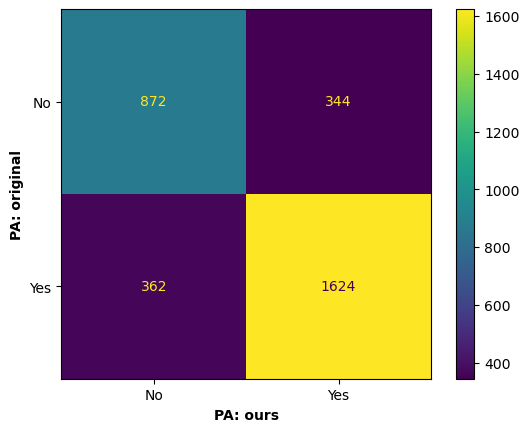

In [79]:
# Checking out where we diverge from the original dataset using a confusion matrix
#  - I would expect there to be more places where we say yes and they say no - this indicates 
#     a general expansion of PAs between the two versions of WDPA that we're using!
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(ORIGINAL_binary, ben_lop_OURS['PA_final'])
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No', 'Yes'])

disp.plot()
plt.xlabel('PA: ours', weight = 'bold')
plt.ylabel('PA: original', weight = 'bold');